In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcParams['figure.dpi'] = 150

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Building information footprint when the number of RNAPs/repressors exists on a distribution

In [6]:
def simrep_pbound_with_noise(p_seq, r_seq, n_NS,
                             p_emat, r_emat, ep_wt, er_wt,
                             mean_p, mean_r, alpha):

    n_p_exponent = np.random.normal(np.log(mean_p), alpha * np.log(mean_p), 1)[0]
    n_r_exponent = np.random.normal(np.log(mean_r), alpha * np.log(mean_r), 1)[0]

    n_p_new = np.exp(n_p_exponent)
    n_r_new = np.exp(n_r_exponent)
    
    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_r = tregs.simulate.get_weight(r_seq, r_emat, e_wt=er_wt)

    z = np.zeros(3)
    z[0] = 1
    z[1] = n_p_new / n_NS * w_p
    z[2] = n_r_new / n_NS * w_r

    return z[1] / np.sum(z)

In [7]:
def get_signal(footprint, region_param):
    signal = np.sum(footprint[(region_param[0]+115):(region_param[1]+116)])
    length = region_param[1] - region_param[0] + 1
    return signal, length

In [8]:
mutant_bank = []
for i in range(10):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [9]:
n_NS = len(genome)
n_p = 3000
n_r = 10
ep_wt = -5
er_wt = -15
mean_p = 5000
mean_r = 10

l_alpha = np.arange(0, 0.5, 0.01)
        
l_stn_ratio_rnap10 = []
l_stn_ratio_rnap35 = []
l_stn_ratio_lacI = []
for alpha in l_alpha:
    rnap10 = []
    rnap35 = []
    lacI = []
    for j in range(10):
        df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                                *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                                    mean_p, mean_r, alpha],
                                preset_mutants=mutant_bank[i])
        
        nbins = 2
        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
        
        region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
        rnap35_signal, rnap35_length = get_signal(footprint, region_params[0])
        rnap10_signal, rnap10_length = get_signal(footprint, region_params[1])
        lacI_signal, lacI_length = get_signal(footprint, region_params[2])

        total_signal = rnap35_signal + rnap10_signal + lacI_signal
        total_noise = np.sum(footprint) - total_signal
        mean_noise = total_noise / (160 - (rnap35_length + rnap10_length + lacI_length))
        
        rnap10.append(rnap10_signal / rnap10_length / mean_noise)
        rnap35.append(rnap35_signal / rnap35_length / mean_noise)
        lacI.append(lacI_signal / lacI_length / mean_noise)
    l_stn_ratio_rnap10.append(np.mean(rnap10))
    l_stn_ratio_rnap35.append(np.mean(rnap35))
    l_stn_ratio_lacI.append(np.mean(lacI))

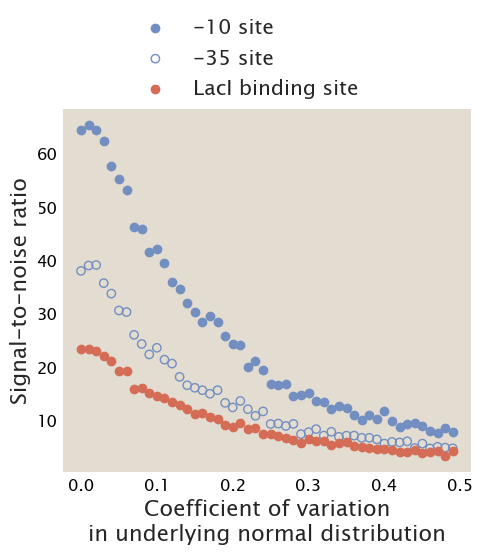

In [10]:
fig, ax = plt.subplots(figsize=(5, 6))
ax.scatter(l_alpha, l_stn_ratio_rnap10, label='-10 site', color='#738FC1')
ax.scatter(l_alpha, l_stn_ratio_rnap35, label='-35 site', facecolors='none', edgecolors='#738FC1', )
ax.scatter(l_alpha, l_stn_ratio_lacI, label='LacI binding site',
           color='#D56C55')
ax.set_xlabel('Coefficient of variation\nin underlying normal distribution', fontsize=16)
ax.set_ylabel('Signal-to-noise ratio',fontsize=16)
ax.legend(bbox_to_anchor=(0.77, 1.3), frameon=False, fontsize=15)

plt.tight_layout()
plt.savefig('../plots/fig12/amplification_bias.pdf')

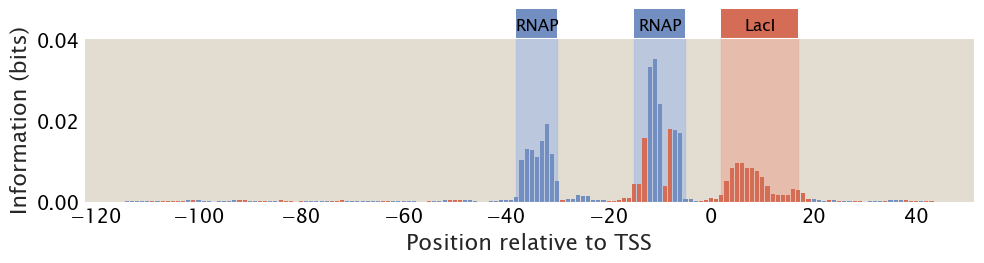

In [11]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15

mean_p = 5000
mean_r = 10
alpha = 0.001

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                        *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                          mean_p, mean_r, alpha])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               outfile='../plots/fig12/amplification_bias_fp1.pdf')

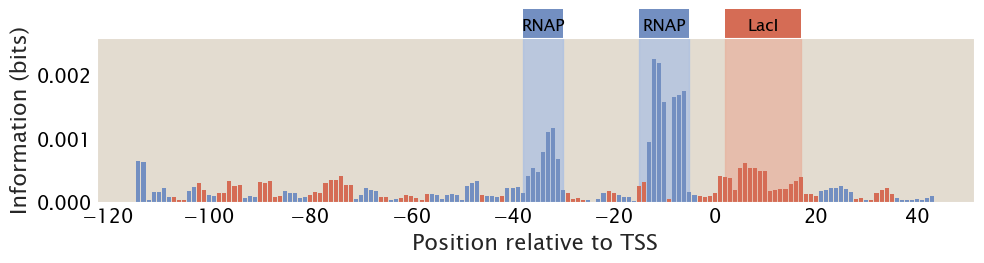

In [12]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15

mean_p = 5000
mean_r = 10
alpha = 0.5

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                        *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                          mean_p, mean_r, alpha])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               outfile='../plots/fig12/amplification_bias_fp2.pdf')

### What happens when the signal is also low?

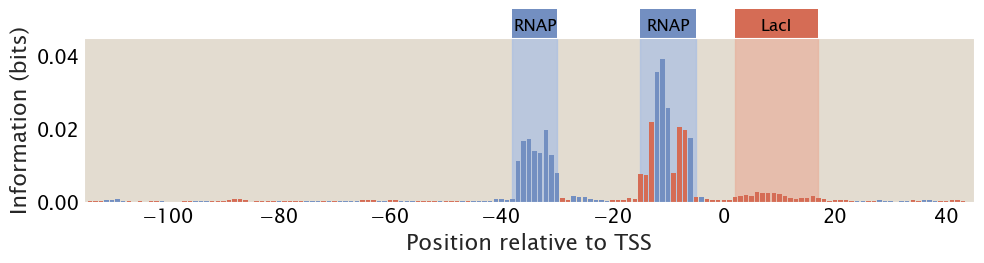

In [7]:
n_NS = len(genome)
n_p = 1000
n_r = 10
ep_wt = -5
er_wt = -13

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               legend_xcoord=1.35,
                               outfile='../rebuttal_plots/figR6_fp1.pdf')

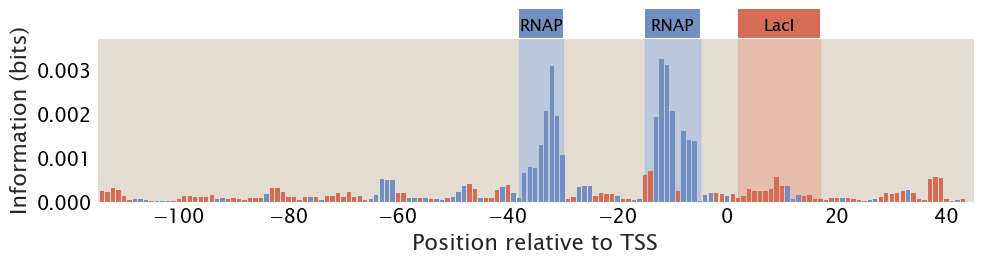

In [10]:
n_NS = len(genome)
ep_wt = -5
er_wt = -13

mean_p = 1000
mean_r = 10
alpha = 0.5

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                        *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                          mean_p, mean_r, alpha])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               outfile='../rebuttal_plots/figR6_fp2.pdf')